## Step 3 - Climate Analysis and Exploration

You are now ready to use Python and SQLAlchemy to do basic climate analysis and data exploration on your new weather station tables. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

* Create a Jupyter Notebook file called `climate_analysis.ipynb` and use it to complete your climate analysis and data exporation.

* Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

* Use SQLAlchemy `create_engine` to connect to your sqlite database.

* Use SQLAlchemy `automap_base()` to reflect your tables into classes and save a reference to those classes called `Station` and `Measurement`.




In [2]:
# Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
# Dependencies for plotting 

import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [4]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [5]:
# Declare a Base using `automap_base()`
BaseReflection = automap_base()

In [6]:
# reflect the tables
BaseReflection.prepare(engine, reflect=True)

In [7]:
#print classes mapped to the Base
BaseReflection.classes.keys()

['measurement', 'station']

In [8]:
# Reflect Database into ORM class
Measurement = BaseReflection.classes.measurement
Station = BaseReflection.classes.station

In [9]:
# Start a session to query the database
session = Session(engine)

### Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame and set the index to the date column.

* Plot the results using the DataFrame `plot` method.

<center><img src='images/precip.png' /></center>

* Use Pandas to print the summary statistics for the precipitation data.

In [10]:
import datetime as dt
# Total dates
session.query(func.count(Measurement.date)).all()

[(19550)]

In [11]:
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [12]:
starting_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(starting_date)

2016-08-23


In [13]:

precipitation = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date>starting_date).\
                order_by(Measurement.date).all()

In [14]:
precipitation_df = pd.DataFrame(precipitation)
precipitation_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,0.00
4,2016-08-24,1.22


<IPython.core.display.Javascript object>


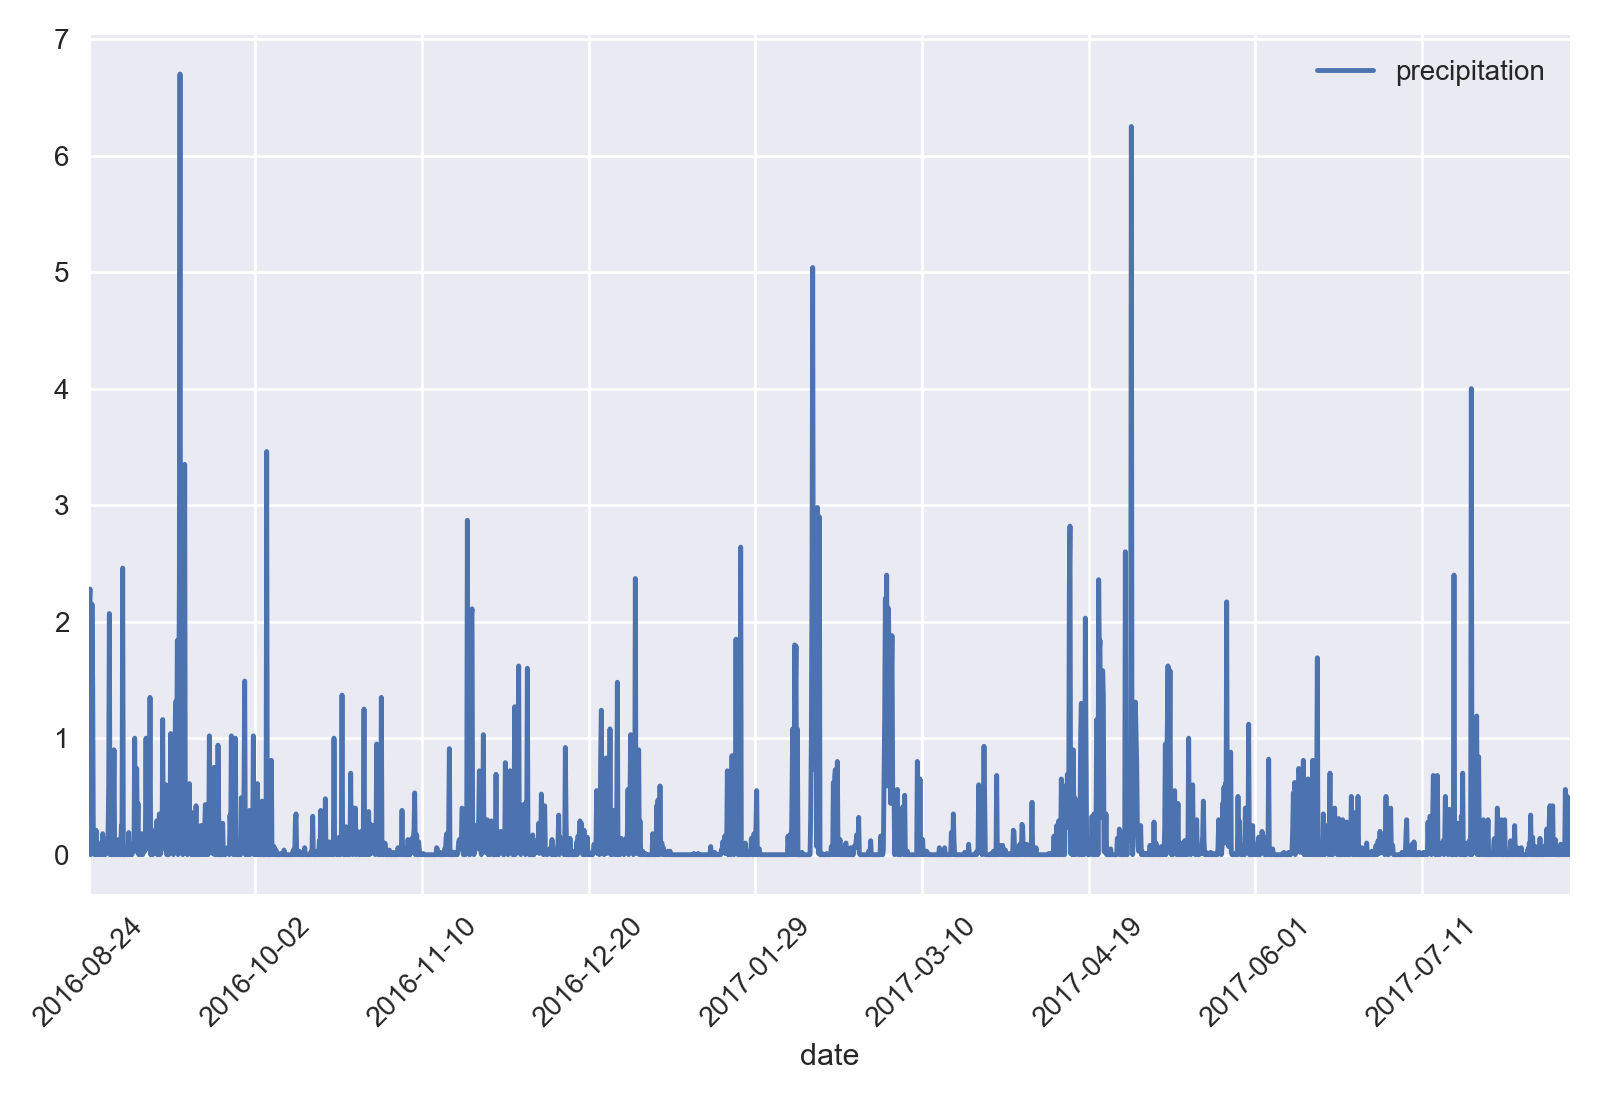

In [15]:
#Plot dataframe
precipitation_df.plot('date', 'prcp')
plt.xlabel("date")
plt.legend(["precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
#Summary 
precipitation_df.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


### Station Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order

  * Which station has the highest number of observations?

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.

  <center><img src='images/temp_hist.png' height="400px" /></center>

In [17]:
# Total stations
session.query(func.count(Station.station)).all()

[(9)]

In [18]:
# Most active stations & station with the highest number of observations
most_active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).all()
print(most_active_stations)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [19]:
# Station with the highest number of observations
busiest_station = most_active_stations[0][0]
print(busiest_station)


USC00519281


In [20]:
# query to pull the last year of precipitation data for the busiest station
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest_station).\
    filter(Measurement.date > starting_date).\
    order_by(Measurement.date).all()
    
    
temp_df = pd.DataFrame(temperature)
temp_df.head()

,station,date,tobs
0,USC00519281,2016-08-24,77
1,USC00519281,2016-08-25,80
2,USC00519281,2016-08-26,80
3,USC00519281,2016-08-27,75
4,USC00519281,2016-08-28,73


<IPython.core.display.Javascript object>


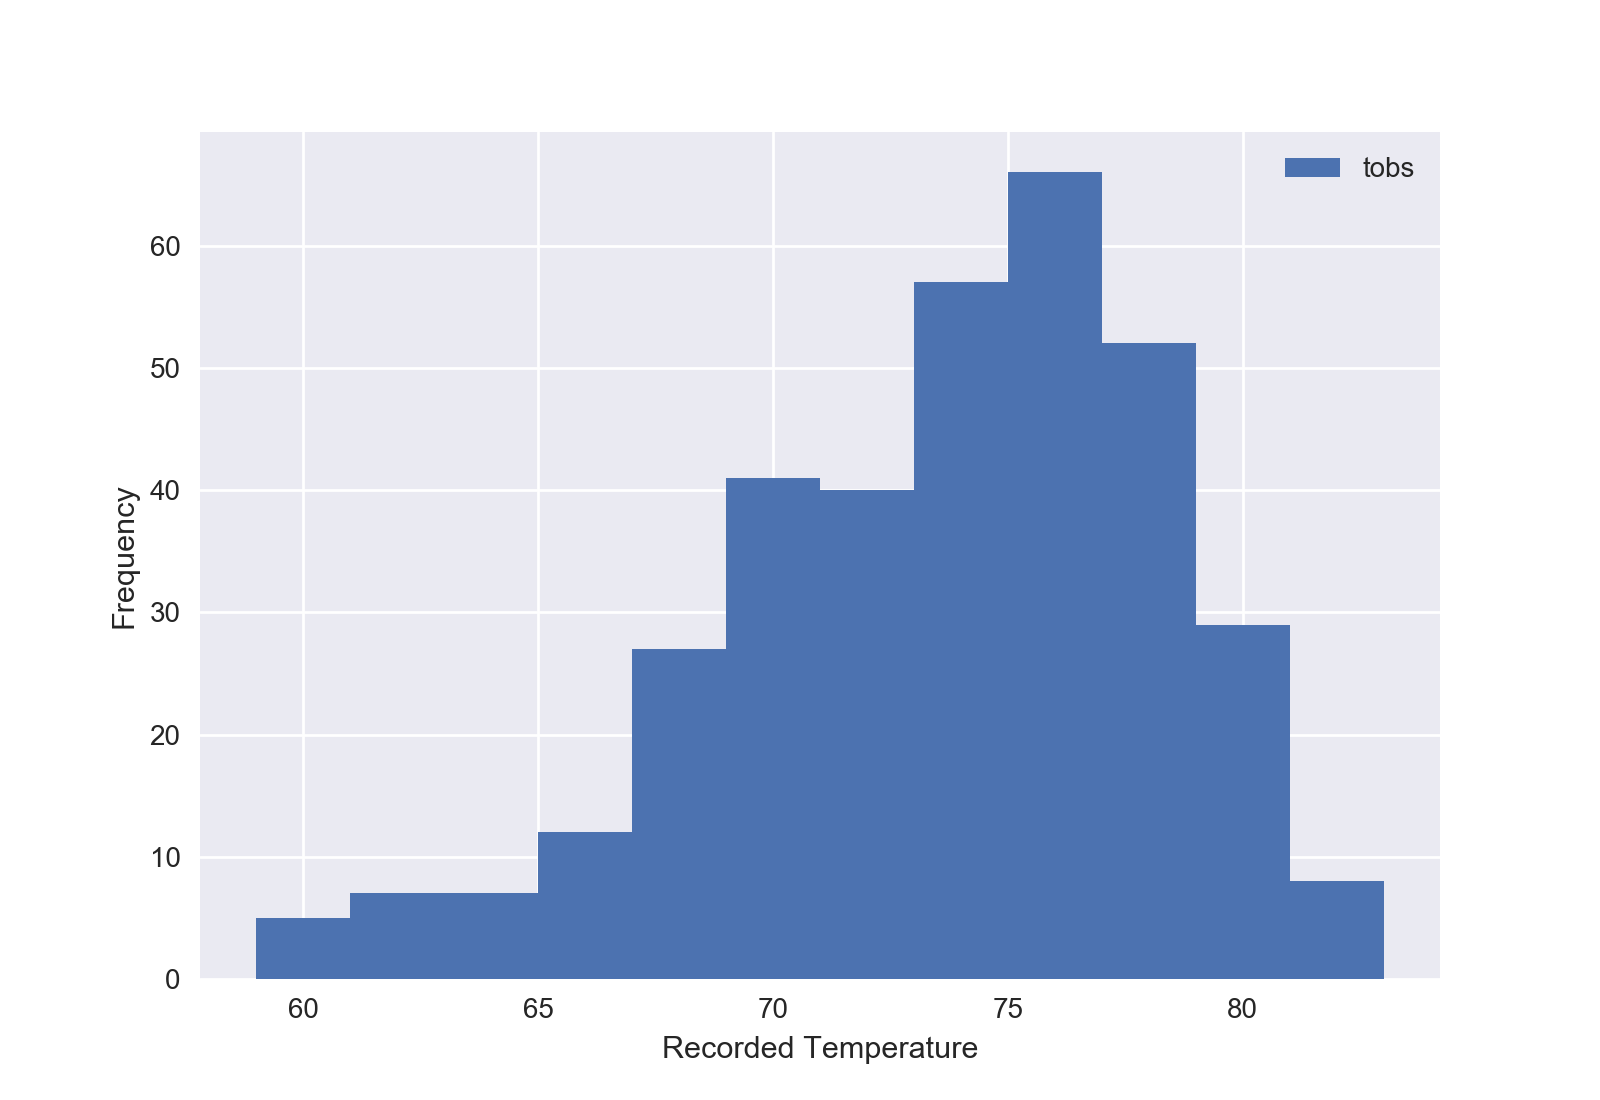

In [21]:
#Plot the results as a histogram with bins=12.

plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.show()

### Temperature Analysis

* Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

<center><img src='images/temp_avg.png' height="400px"/></center>

In [22]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
#and return the minimum, average, and maximum temperatures for that range of dates

# calc_temps function
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.date >= start_date).filter(Measurement.date <=end_date).all()


In [23]:
# my trip previous year
previous_trip_start = dt.date(2016, 3, 1)
previous_trip_end = dt.date(2016, 3, 9)
temp_range = calc_temps(previous_trip_start, previous_trip_end)
print(temp_range)

[(62, 70.10169491525424, 78)]


<IPython.core.display.Javascript object>


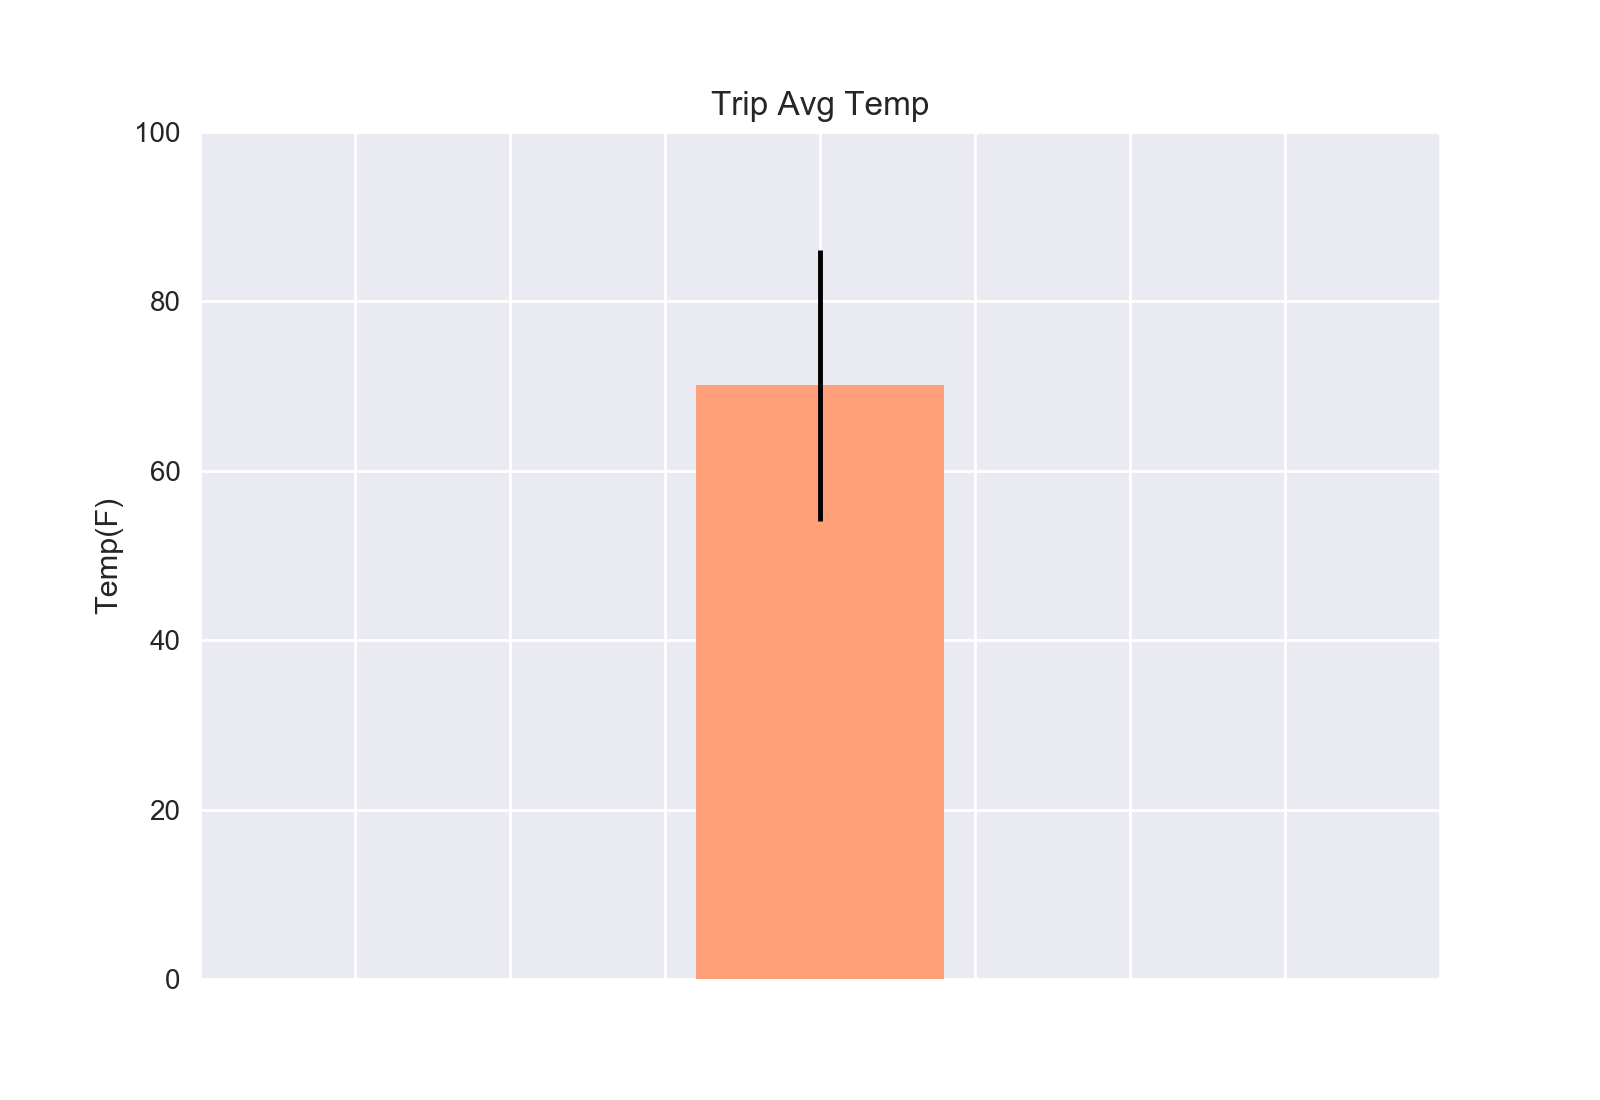

<IPython.core.display.Javascript object>


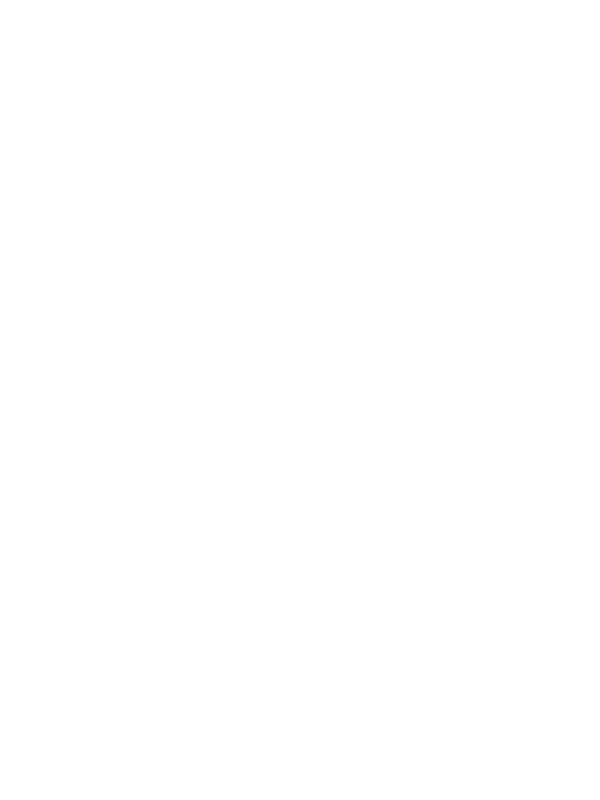

In [24]:
#plot bar chart
avg_temp = temp_range[0][1]
min_temp = temp_range[0][0]
max_temp = temp_range[0][2]
peak_to_peak = max_temp - min_temp
fig, ax = plt.subplots()
bar_chart = ax.bar(1, avg_temp, color = 'lightsalmon', yerr = peak_to_peak)
ax.set_ylabel('Temp(F)')
ax.set_title('Trip Avg Temp')
plt.ylim(0, 100)
plt.xlim(-1, 3)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom='off',      
    top='off',         
    labelbottom='off')
plt.figure(figsize=(3,4))
plt.show()